<a href="http://laf-fabric.readthedocs.org/en/latest/" target="_blank"><img align="left" src="images/laf-fabric-xsmall.png"/></a>
<a href="http://www.godgeleerdheid.vu.nl/etcbc" target="_blank"><img align="left" src="images/VU-ETCBC-xsmall.png"/></a>
<a href="http://www.persistent-identifier.nl/?identifier=urn%3Anbn%3Anl%3Aui%3A13-048i-71" target="_blank"><img align="left"src="images/etcbc4easy-small.png"/></a>
<a href="http://tla.mpi.nl" target="_blank"><img align="right" src="images/TLA-xsmall.png"/></a>
<a href="http://www.dans.knaw.nl" target="_blank"><img align="right"src="images/DANS-xsmall.png"/></a>

# Cooccurrences of lexemes between the books of the Hebrew Bible

# Research Question

What does linguistic variation between bible books tell us about their origin, and about the evolution and transmission of their texts?

# Method

We study the co-occurrences of lexemes across the books of the bible and represent this data in a undirected weighted graph, where the books are nodes.
There are edges between very pair of books that share a lexeme occurrence. 
Edges are weighted: the more lexemes are shared by a pair of books, the heavier the edge. However, the weight is corrected and normalized as well. 

* *correction*: frequent lexemes contribute less to the weight than rare lexemes,
* *normalization*: the weight contribution of a lexeme is divided by the number of lexemes in the union of two books.

The initial plan was to consider only common nouns, but we are also experimenting with nouns in general, verbs, and all lexemes.
Moreover, we also experiment with two measures of normalisation: 

* *normal*: divide by the sum of the number of distinct lexemes in the concatenation of two books
* *quadratic*: as in *normal*, but divide by the square of the sum.

More formally:

Let $B$ be the set of books in the Bible.

The *support* of a lexeme $l$ is defined as $S(l) = card\{b \in B\ \vert\ l \in b\}$.

The lexeme content of book $b$ is defined as $L(b) = \{l\ \vert\ l \in b\}$,

and the lexeme content of two books $b_1$ and $b_2$ is defined as $L(b_1, b_2) = L(b_1)\ \cup\ L(b_2)$.

The cooccurrency of those two books is defined as $C(b_1, b_2) = L(b_1)\ \cap\ L(b_2)$.

We now define two measures of *weight* of a cooccurrences edge between two books $b_1$ and $b_2$:

$$W_1(b_1,b_2) = {\sum \{{1\over S(l)}\ \vert\ l \in C(b_1, b_2)\} \over card\,L(b_1, b_2)}$$

$$W_2(b_1,b_2) = {\sum \{{1\over S(l)}\ \vert\ l \in C(b_1, b_2)\} \over (card\,L(b_1, b_2))^2}$$

# Compute

Import the python modules, the plot modules, the LAF-Fabric module (``laf``) and initialize the ``laf`` processor.

In [1]:
import sys
import collections
import matplotlib.pyplot as plt
from laf.fabric import LafFabric
fabric = LafFabric()

  0.00s This is LAF-Fabric 4.4.7
API reference: http://laf-fabric.readthedocs.org/en/latest/texts/API-reference.html
Feature doc: http://shebanq-doc.readthedocs.org/en/latest/texts/welcome.html



Load the data, especially the features we need.
Note that the task will be named *cooccurrences*.
After loading we retrieve the names by which we can access the various pieces of the LAF data.

In [2]:
fabric.load('etcbc4', '--', 'cooccurrences', {
    "xmlids": {"node": False, "edge": False},
    "features": ("otype sp lex_utf8 book", ""),
})
exec(fabric.localnames.format(var='fabric'))

  0.00s LOADING API: please wait ... 
  0.10s INFO: USING DATA COMPILED AT: 2014-07-23T09-31-37
  2.91s LOGFILE=/Users/dirk/Dropbox/laf-fabric-output/etcbc4/cooccurrences/__log__cooccurrences.txt
  2.91s INFO: DATA LOADED FROM SOURCE etcbc4 AND ANNOX -- FOR TASK cooccurrences AT 2014-11-12T10-05-55


For your convenience:

* *NN*: iterator of nodes in primary data order
* *F*: feature data

You can inspect the API by giving commands like ``F.*?``, ``NN??``

In [3]:
F.*?

In [4]:
NN??

We are going to generate data files for [Gephi](https://gephi.org), in its native XML format. 
Here we specify the subtasks and weighing methods.

* *Subtasks* correspond to the kind of lexemes we are counting.
* *Methods* correspond to the kind of normalization that we are applying: dividing by the sum or the square of the sum.

We also spell out the XML header of a Gephi file

In [3]:
tasks = {
    'noun_common': {
        '1': outfile("noun_common_1.gexf"),
        '2': outfile("noun_common_2.gexf"),
    },
    'noun_proper': {
        '1': outfile("noun_proper_1.gexf"),
        '2': outfile("noun_proper_2.gexf"),
    },
    'verb': {
        '1': outfile("verb_1.gexf"),
        '2': outfile("verb_2.gexf"),
    },
    'verb-noun_common': {
        '1': outfile("verb-noun_common_1.gexf"),
        '2': outfile("verb-noun_common_2.gexf"),
    },
    'all': {
        '1': outfile("all_1.gexf"),
        '2': outfile("all_2.gexf"),
    },
}

methods = {
    '1': lambda x, y: float(x) / y,
    '2': lambda x, y: float(x) / y / y,
}

data_header = '''<?xml version="1.0" encoding="UTF-8"?>
<gexf xmlns:viz="http:///www.gexf.net/1.2draft/viz" xmlns="http://www.gexf.net/1.1draft" version="1.2">
<meta>
<creator>LAF-Fabric</creator>
</meta>
<graph defaultedgetype="undirected" idtype="string" type="static">
'''

Initialization

In [4]:
book_name = None
books = []
lexemes = collections.defaultdict(lambda: collections.defaultdict(lambda:collections.defaultdict(lambda:0)))
lexeme_support_book = collections.defaultdict(lambda: collections.defaultdict(lambda: {}))

Walk through the relevant nodes and collect the data:

In [5]:
for node in NN():
    this_type = F.otype.v(node)
    if this_type == "word":
        lexeme = F.lex_utf8.v(node)

        lexemes['all'][book_name][lexeme] += 1
        lexeme_support_book['all'][lexeme][book_name] = 1

        p_o_s = F.sp.v(node)
        if p_o_s == "subs":
            lexemes['noun_common'][book_name][lexeme] += 1
            lexeme_support_book['noun_common'][lexeme][book_name] = 1
            lexemes['verb-noun_common'][book_name][lexeme] += 1
            lexeme_support_book['verb-noun_common'][lexeme][book_name] = 1
        elif p_o_s == 'nmpr':
            lexemes['noun_proper'][book_name][lexeme] += 1
            lexeme_support_book['noun_proper'][lexeme][book_name] = 1
        elif p_o_s == "verb":
            lexemes['verb'][book_name][lexeme] += 1
            lexeme_support_book['verb'][lexeme][book_name] = 1
            lexemes['verb-noun_common'][book_name][lexeme] += 1
            lexeme_support_book['verb-noun_common'][lexeme][book_name] = 1

    elif this_type == "book":
        book_name = F.book.v(node)
        books.append(book_name)
        msg("{} ".format(book_name))
msg("Done")

    30s Genesis 
    30s Exodus 
    30s Leviticus 
    30s Numeri 
    31s Deuteronomium 
    31s Josua 
    31s Judices 
    31s Samuel_I 
    31s Samuel_II 
    31s Reges_I 
    31s Reges_II 
    32s Jesaia 
    32s Jeremia 
    32s Ezechiel 
    32s Hosea 
    32s Joel 
    32s Amos 
    32s Obadia 
    32s Jona 
    32s Micha 
    32s Nahum 
    32s Habakuk 
    32s Zephania 
    32s Haggai 
    32s Sacharia 
    32s Maleachi 
    32s Psalmi 
    33s Iob 
    33s Proverbia 
    33s Ruth 
    33s Canticum 
    33s Ecclesiastes 
    33s Threni 
    33s Esther 
    33s Daniel 
    33s Esra 
    33s Nehemia 
    33s Chronica_I 
    33s Chronica_II 
    33s Done


Sort the data according to the various subtasks, and compute the edges with their weights.

In [6]:
nodes_header = '''<nodes count="{}">\n'''.format(len(books))

for this_type in tasks:

    lexeme_support = {}
    for lexeme in lexeme_support_book[this_type]:
        lexeme_support[lexeme] = len(lexeme_support_book[this_type][lexeme])
         
    book_size = collections.defaultdict(lambda: 0)
    for book in lexemes[this_type]:
        book_size[book] = len(lexemes[this_type][book])
         
    node_data = []
    for node in range(len(books)):
        node_data.append('''<node id="{}" label="{}"/>\n'''.format(node + 1, books[node]))

    edge_id = 0
    edge_data = collections.defaultdict(lambda: [])
    for src in range(len(books)):
        for tgt in range(src + 1, len(books)):
            book_src = books[src]
            book_tgt = books[tgt]
            lexemes_src = {}
            lexemes_tgt = {}
            lexemes_src = lexemes[this_type][book_src]
            lexemes_tgt = lexemes[this_type][book_tgt]
            intersection_size = 0
            weights = collections.defaultdict(lambda: 0)
            for lexeme in lexemes_src:
                if lexeme not in lexemes_tgt:
                    continue
                pre_weight = lexeme_support[lexeme]
                for this_method in tasks[this_type]:
                    weights[this_method] += methods[this_method](1000, pre_weight)
                intersection_size += 1
            combined_size = book_size[book_src] + book_size[book_tgt] - intersection_size
            edge_id += 1
            for this_method in tasks[this_type]:
                edge_data[this_method].append('''<edge id="{}" source="{}" target="{}" weight="{:.3g}"/>\n'''.
                    format(edge_id, src + 1, tgt + 1, weights[this_method]/combined_size))
            
    for this_method in tasks[this_type]:
        edges_header = '''<edges count="{}">\n'''.format(len(edge_data[this_method]))
        out_file = tasks[this_type][this_method]
        out_file.write(data_header)

        out_file.write(nodes_header)
        for node_line in node_data:
            out_file.write(node_line)
        out_file.write("</nodes>\n")

        out_file.write(edges_header)
        for edge_line in edge_data[this_method]:
            out_file.write(edge_line)
        out_file.write("</edges>\n")
        out_file.write("</graph></gexf>\n")

    msg("{}: nodes:  {}; edges: {}".format(this_type, len(books), edge_id))
close()

    43s all: nodes:  39; edges: 741
    43s noun_proper: nodes:  39; edges: 741
    44s verb-noun_common: nodes:  39; edges: 741
    44s verb: nodes:  39; edges: 741
    44s noun_common: nodes:  39; edges: 741
    44s Results directory:
/Users/dirk/Dropbox/laf-fabric-output/etcbc4/cooccurrences

__log__cooccurrences.txt               1115 Wed Nov 12 11:06:39 2014
all_1.gexf                            41738 Wed Nov 12 11:06:39 2014
all_2.gexf                            42256 Wed Nov 12 11:06:39 2014
noun_common_1.gexf                    41714 Wed Nov 12 11:06:39 2014
noun_common_2.gexf                    42239 Wed Nov 12 11:06:39 2014
noun_proper_1.gexf                    41868 Wed Nov 12 11:06:39 2014
noun_proper_2.gexf                    42548 Wed Nov 12 11:06:39 2014
verb-noun_common_1.gexf               41751 Wed Nov 12 11:06:39 2014
verb-noun_common_2.gexf               42247 Wed Nov 12 11:06:39 2014
verb_1.gexf                           41755 Wed Nov 12 11:06:39 2014
verb_2.gexf  

In [10]:
!head -n 100 {my_file('verb-noun_common_1.gexf')}

<?xml version="1.0" encoding="UTF-8"?>
<gexf xmlns:viz="http:///www.gexf.net/1.2draft/viz" xmlns="http://www.gexf.net/1.1draft" version="1.2">
<meta>
<creator>LAF-Fabric</creator>
</meta>
<graph defaultedgetype="undirected" idtype="string" type="static">
<nodes count="39">
<node id="1" label="Genesis"/>
<node id="2" label="Exodus"/>
<node id="3" label="Leviticus"/>
<node id="4" label="Numeri"/>
<node id="5" label="Deuteronomium"/>
<node id="6" label="Josua"/>
<node id="7" label="Judices"/>
<node id="8" label="Samuel_I"/>
<node id="9" label="Samuel_II"/>
<node id="10" label="Reges_I"/>
<node id="11" label="Reges_II"/>
<node id="12" label="Jesaia"/>
<node id="13" label="Jeremia"/>
<node id="14" label="Ezechiel"/>
<node id="15" label="Hosea"/>
<node id="16" label="Joel"/>
<node id="17" label="Amos"/>
<node id="18" label="Obadia"/>
<node id="19" label="Jona"/>
<node id="20" label="Micha"/>
<node id="21" label="Nahum"/>
<node id="22" label="Habakuk"/>
<node id="23" label="Zephania"/>
<node 

# Visualization

The output files can be loaded into Gephi and subjected to various graph rendering algorithms.
After some playing you can get this out of it:

<img align="center" src="files/CommonNounsVerbsWeight.png"/>

The Python module *networkx* is also capable of graph layout, let us try the most obvious methods.

In [8]:
%matplotlib inline
import networkx as nx

In [9]:
g_nc1 = nx.read_gexf(my_file('verb-noun_common_1.gexf'), relabel=True)

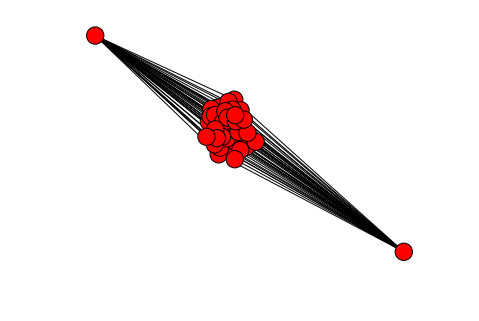

In [10]:
nx.draw_spring(g_nc1)

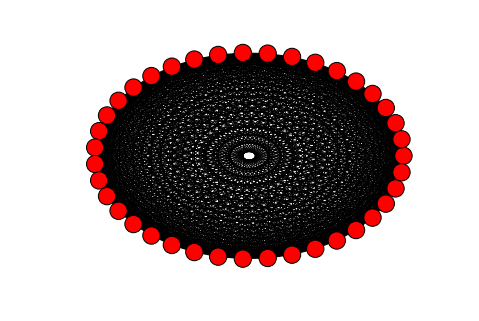

In [11]:
nx.draw_circular(g_nc1)

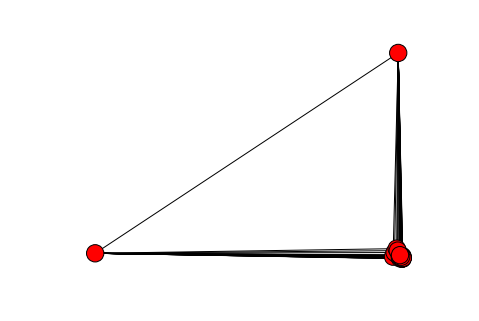

In [12]:
nx.draw_spectral(g_nc1)

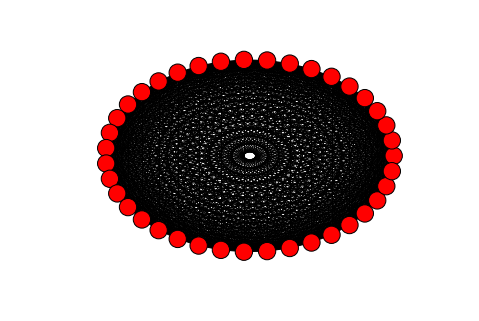

In [13]:
nx.draw_shell(g_nc1)

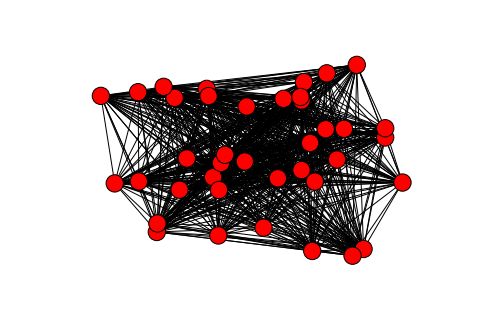

In [14]:
nx.draw_random(g_nc1)